In [2]:
#Import packages
import pandas as pd
import numpy as np
import os

from functions import plotting_raw_data, remove_outliers, error_plot, plot_cpt_data, plot_cpt_data_ML_prediction, plot_cpt_data_NW_site

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

In [3]:
######################## Define the text size of each plot globally ###########
SMALL_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
######################## Define the text size of each plot globally ###########

In [4]:
# =============================================================================
# Import CPT Dataset
# =============================================================================

# File path
file_path = r"..\data\CPT_PremstallerGeotechnik_revised.csv"

# Read the CSV file into a DataFrame
df_raw = pd.read_csv(file_path, low_memory=False)

# Select only SCPTu data
df_SCPTu = df_raw[df_raw['test_type'] == 'SCPTu']
# Select only SCPT data
df_SCPT = df_raw[df_raw['test_type'] == 'SCPT']
# Select both SCPTu and SPT data
df_SCPTu_SCPT = df_raw[(df_raw['test_type'] == 'SCPTu') | (df_raw['test_type'] == 'SCPT')]
df_SCPTu_SCPT_mean = df_raw[(df_raw['test_type'] == 'SCPTu') | (df_raw['test_type'] == 'SCPT')]

selected_columns_x_average = ['qc (MPa)', 'fs (kPa)', 'Rf (%)', 'u0 (kPa)', "σ',v (kPa)"]

for column in selected_columns_x_average:
     df_SCPTu_SCPT = df_SCPTu_SCPT.copy()
     df_SCPTu_SCPT[column] = df_SCPTu_SCPT.loc[:, column]#.rolling(window=50).mean()

     df_SCPTu_SCPT_mean = df_SCPTu_SCPT_mean.copy()
     df_SCPTu_SCPT_mean[column+"_mean"] = df_SCPTu_SCPT_mean.loc[:, column]#.rolling(window=50).mean()

df_SCPTu_SCPT = df_SCPTu_SCPT.dropna(subset=['Vs (m/s)'])
df_SCPTu_SCPT_mean = df_SCPTu_SCPT_mean.dropna(subset=['Vs (m/s)'])

# count number of tests in both subsets
SCPTu_number = df_SCPTu['ID'].nunique()
SCPT_number = df_SCPT['ID'].nunique()
combined_number = df_SCPTu_SCPT['ID'].nunique()


print('Preprocessing:\n')
print('Number of tests in SCPTu =', SCPTu_number)
print('Number of tests in SCPT =', SCPT_number)
print('Number of tests in SCPTu and SCPT =', combined_number)

Preprocessing:

Number of tests in SCPTu = 50
Number of tests in SCPT = 46
Number of tests in SCPTu and SCPT = 96


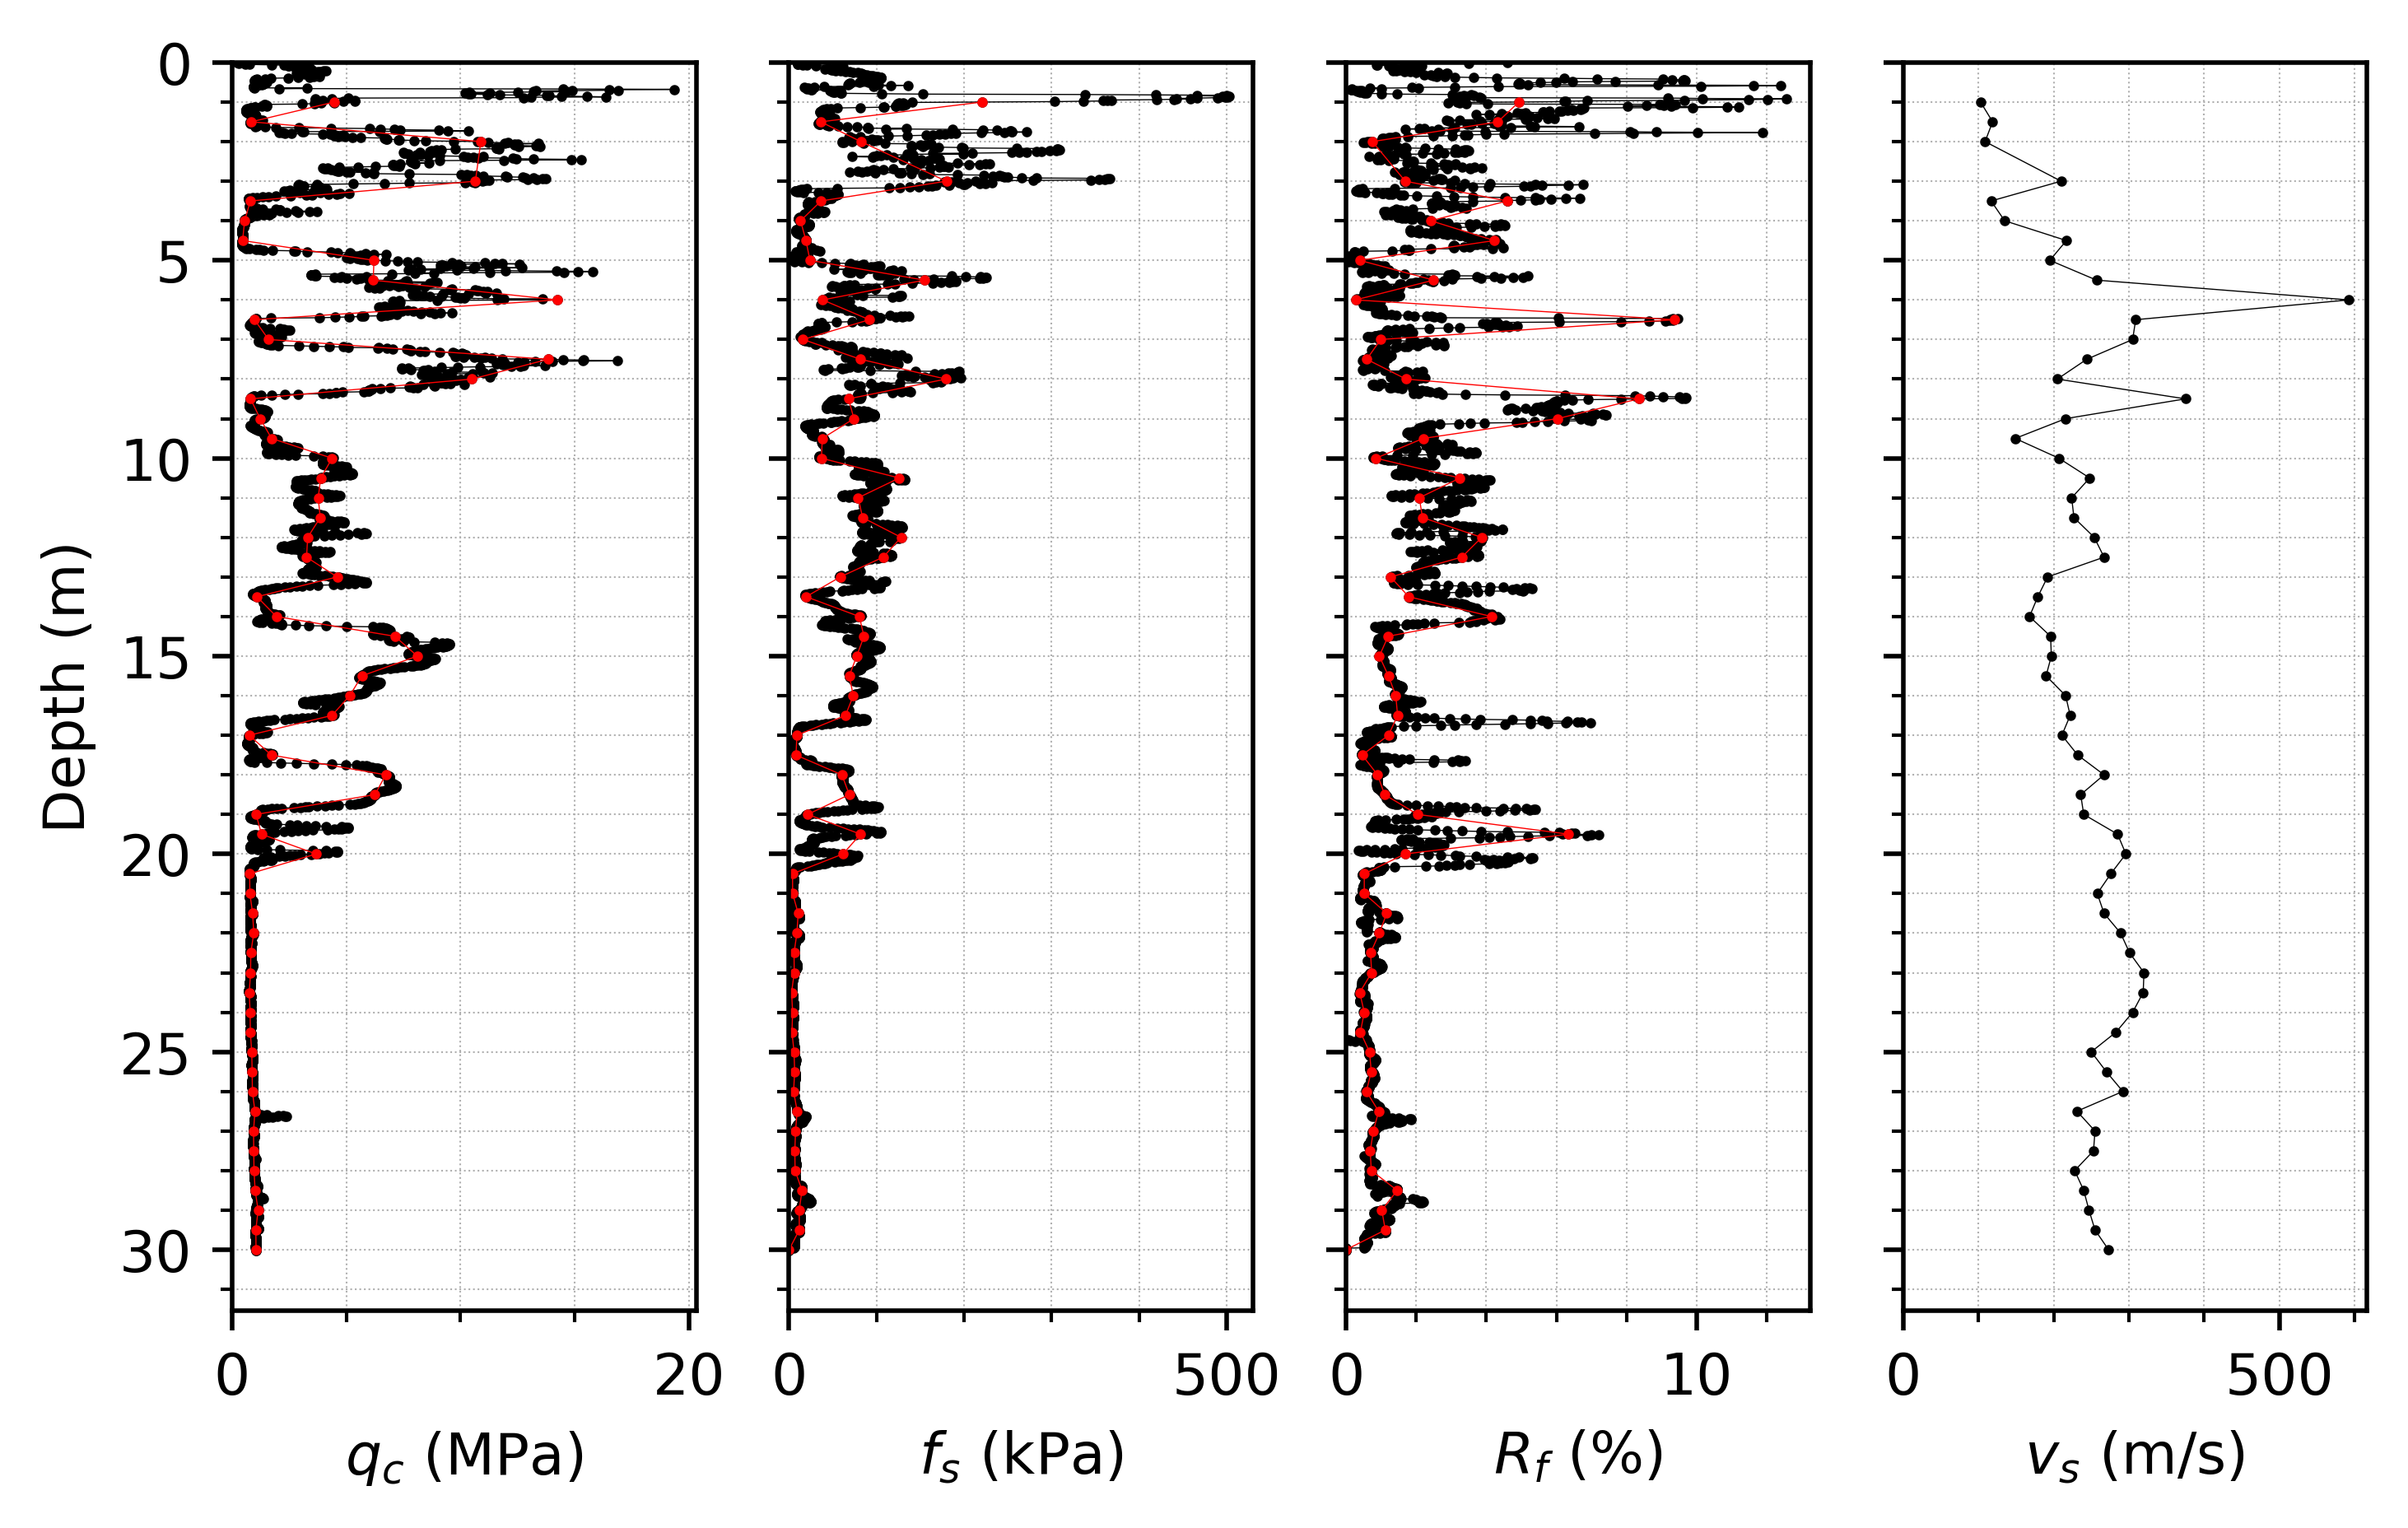

In [8]:
# =============================================================================
# Plotting the data and Selecting features
# =============================================================================
# Plotting CPT data 
cm = 1/2.54  # centimeters in inches

# Select columns
selected_columns_x = ['Depth (m)','qc (MPa)', 'fs (kPa)','Rf (%)','Vs (m/s)'] #for Machine learning features
plot_columns_x_label = ['Depth (m)','$q_c$ (MPa)', '$f_s$ (kPa)','$R_f$ (%)', '$v_s$ (m/s)'] #for plotting purpose

#Plot CPT: raw data and mean data
unique_ids = df_SCPTu_SCPT_mean.loc[:,'ID'].unique()
id_value = np.random.choice(unique_ids)
plot_cpt_data((17*cm, 10*cm), selected_columns_x, df_raw,
              df_SCPTu_SCPT_mean, id_value=id_value,
              plot_columns_x_label=plot_columns_x_label)

plt.savefig(f"..\\graphics\A_CPT_RAW_filterd_id_{id_value}.png", dpi=700)

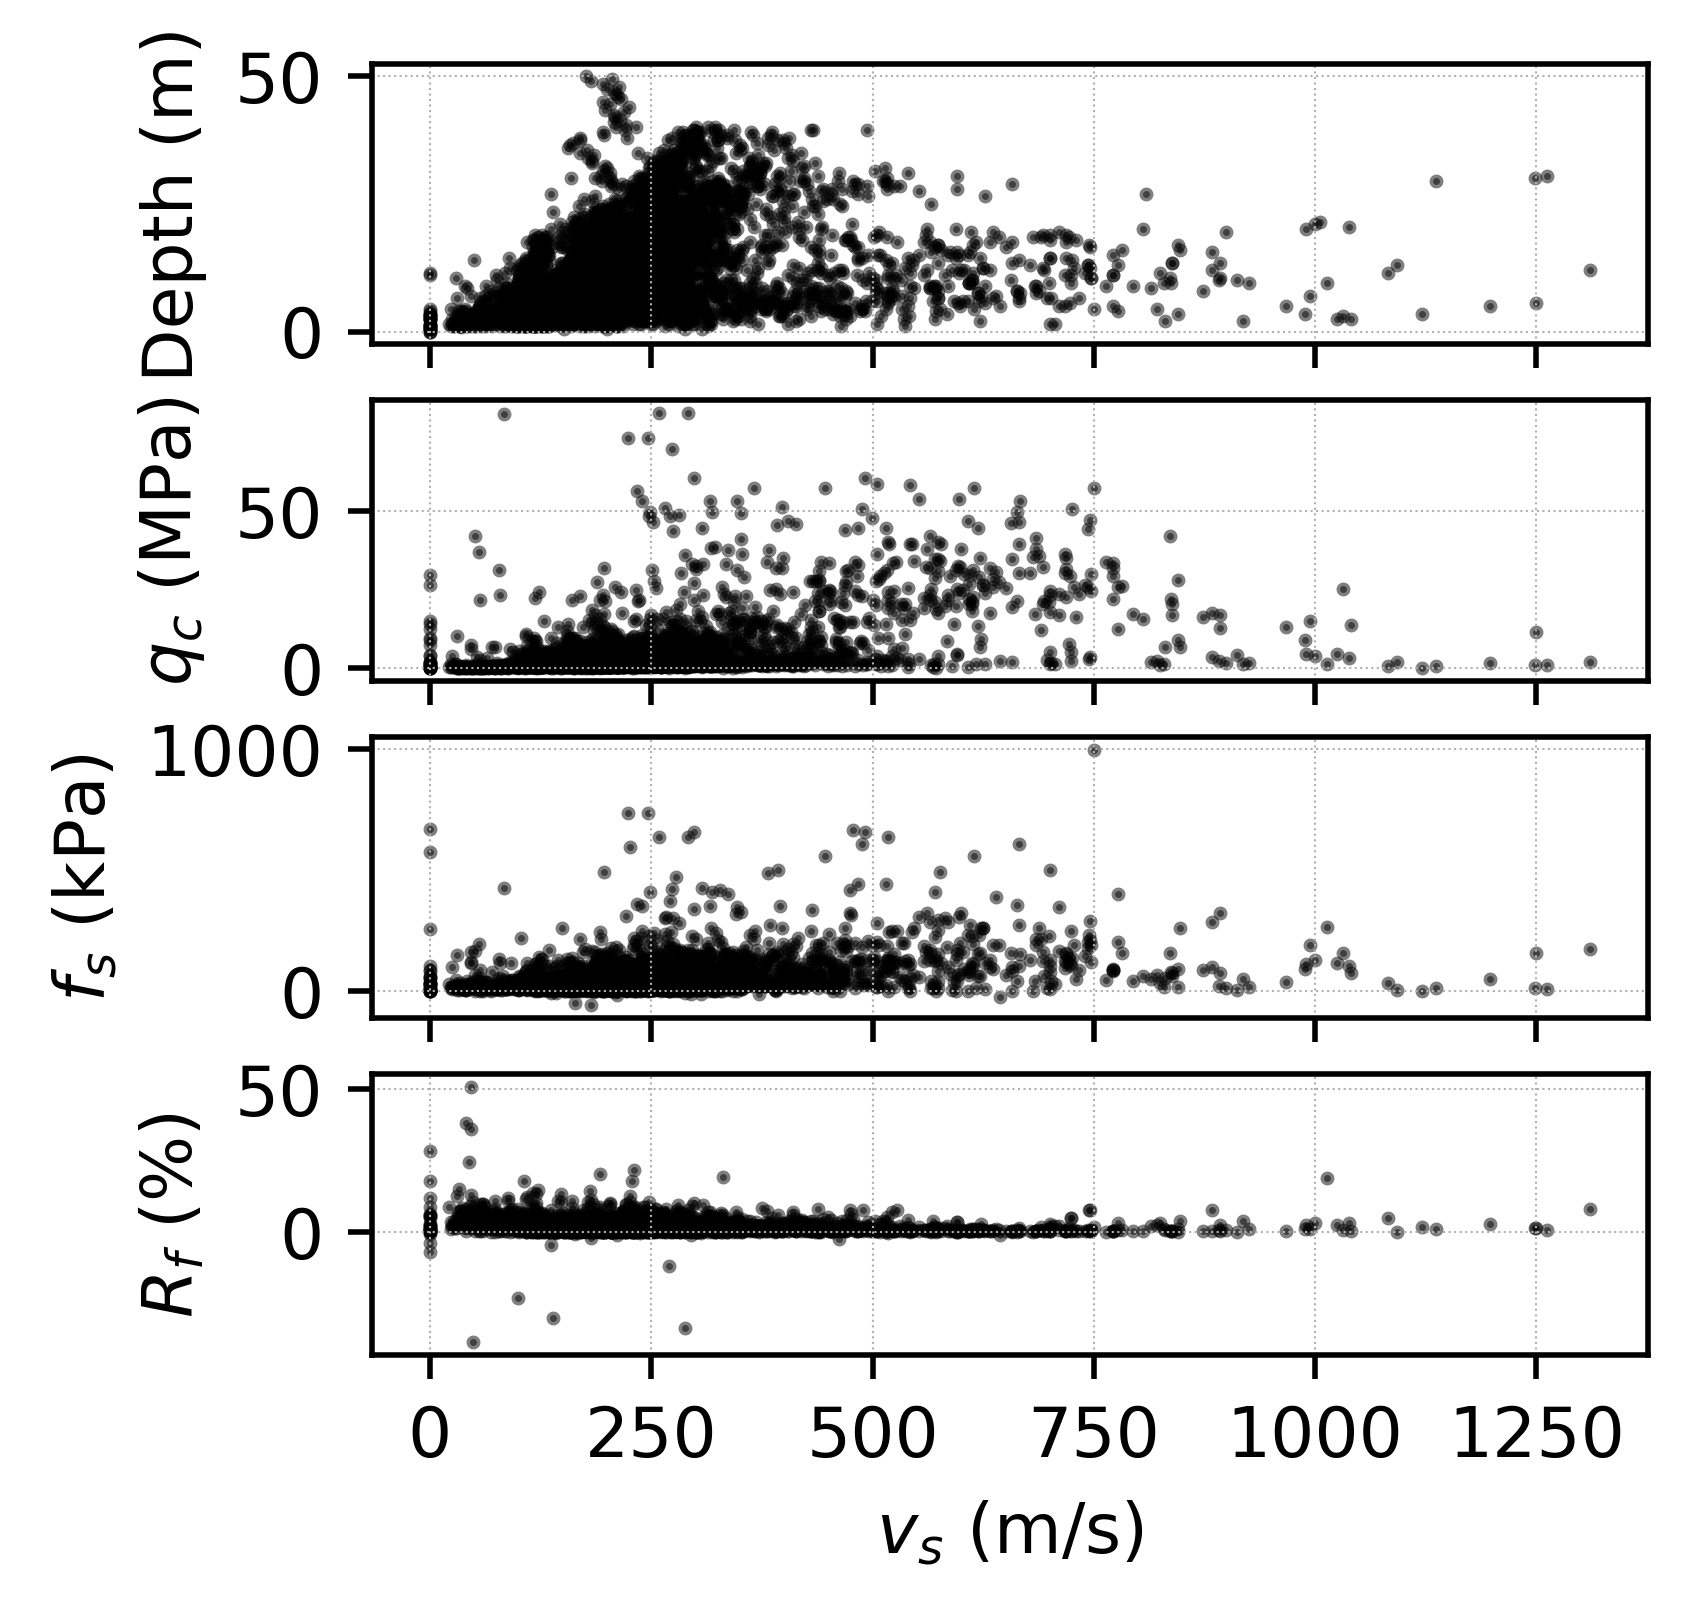

In [42]:
# Plotting training data 

X = df_SCPTu_SCPT[selected_columns_x[:-1]]#.to_numpy()
y = df_SCPTu_SCPT['Vs (m/s)']#.to_numpy()

s = 1  # Adjust the marker size as needed
color = 'k'  # Adjust the marker color as needed
alpha = 0.5

#Plot scatter points: raw data points as
fig, axes = plt.subplots(4, 1, figsize=(8*cm, 8*cm), dpi=500, sharex=True)
plotting_raw_data(X,y, alpha, s, color, True, axes, plot_columns_x_label, 'Raw data', False)

########################### REMOVE outliers
#df_SCPTu_SCPT = remove_outliers(df_SCPTu_SCPT, 'Vs (m/s)')
#df_SCPTu_SCPT = df_SCPTu_SCPT[(df_SCPTu_SCPT['Vs (m/s)'] > 0)]

#X = df_SCPTu_SCPT[selected_columns_x[:-1]]#.to_numpy()
#y = df_SCPTu_SCPT['Vs (m/s)']#.to_numpy()
########################### REMOVE outliers

#plotting_raw_data(X,y, alpha, s, 'r', 'Removed outliers', False, axes, plot_columns_x_label)
# Adjust layout to prevent overlapping
plt.subplots_adjust(left=0.18, right=0.99, top=0.97, bottom=0.15, wspace=0.15, hspace=0.2)
plt.savefig("..\\graphics\B_Raw_data.png", dpi = 1000)

In [43]:
# =============================================================================
# Training of XGB model
# =============================================================================
import xgboost as xgb
import optuna
from optuna.visualization import plot_param_importances, plot_optimization_history

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=2)

def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    param = {
        "objective": "reg:squarederror",
        'n_estimators': trial.suggest_int('n_estimators', 1, 100),
        'tree_method': 'hist',
        "verbosity": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.5, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "reg_alpha":trial.suggest_float("reg_alpha", 0.01, 1.0),
        "reg_lambda":trial.suggest_float("reg_lambda", 0.01, 1.0),
    }

    model = xgb.XGBRegressor(**param, random_state=42)
    score = cross_val_score(model, X=X_train, y=y_train, scoring="r2", n_jobs=-1, cv=10, verbose=0)
    
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-02-08 09:23:19,040] A new study created in memory with name: no-name-b3f2453b-0172-44e6-b226-d4b3e27716e3
[I 2024-02-08 09:23:21,608] Trial 0 finished with value: 0.013452877868449297 and parameters: {'n_estimators': 14, 'learning_rate': 0.0014610105032378726, 'max_depth': 9, 'subsample': 0.22562476340607118, 'reg_alpha': 0.06920947228290655, 'reg_lambda': 0.05717027000902345}. Best is trial 0 with value: 0.013452877868449297.
[I 2024-02-08 09:23:22,111] Trial 1 finished with value: 0.23717186925179212 and parameters: {'n_estimators': 32, 'learning_rate': 0.3410122301893108, 'max_depth': 10, 'subsample': 0.8317435663928229, 'reg_alpha': 0.3443115359768859, 'reg_lambda': 0.6579494473646151}. Best is trial 1 with value: 0.23717186925179212.
[I 2024-02-08 09:23:22,285] Trial 2 finished with value: 0.0641742318177569 and parameters: {'n_estimators': 72, 'learning_rate': 0.0015834817399392475, 'max_depth': 3, 'subsample': 0.9439172695085289, 'reg_alpha': 0.2599815044735798, 'reg_lam

In [44]:
# Plot optimization history
plot_optimization_history(study)

In [45]:
# Plot parameter importances
plot_param_importances(study)

In [46]:
#Print best hyperparameters of the optimization
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 62, 'learning_rate': 0.06812493105697867, 'max_depth': 4, 'subsample': 0.8605533199929554, 'reg_alpha': 0.9426291456499102, 'reg_lambda': 0.8266736379845124}
Best RMSE: 0.41273535416597973


In [47]:
best_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 20,
    'tree_method': 'hist',
    "verbosity": 1,
    'learning_rate': 0.3,
    'max_depth': 5,
    'subsample': 0.7,
    'reg_alpha': 0.7,
    'reg_lambda': 0.7,
    'n_jobs': None,
}

# Update with the best hyperparameters
best_params.update(study.best_params)

# Create the final XGBRegressor with the best hyperparameters
final_model = xgb.XGBRegressor(**best_params)

# Train the final model with the best hyperparameters
final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06812493105697867,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=62, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [48]:
print('Performance of XGB ML model on the test data:\n')
# Check performance on test data
y_pred = final_model.predict(X_test)
# Calculate the R-squared score, Mean squared error
score = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Test Data - R2: {round(score, 3)}, MSE: {round(mse, 3)}.')

Performance of XGB ML model on the test data:

Test Data - R2: 0.46, MSE: 8841.384.


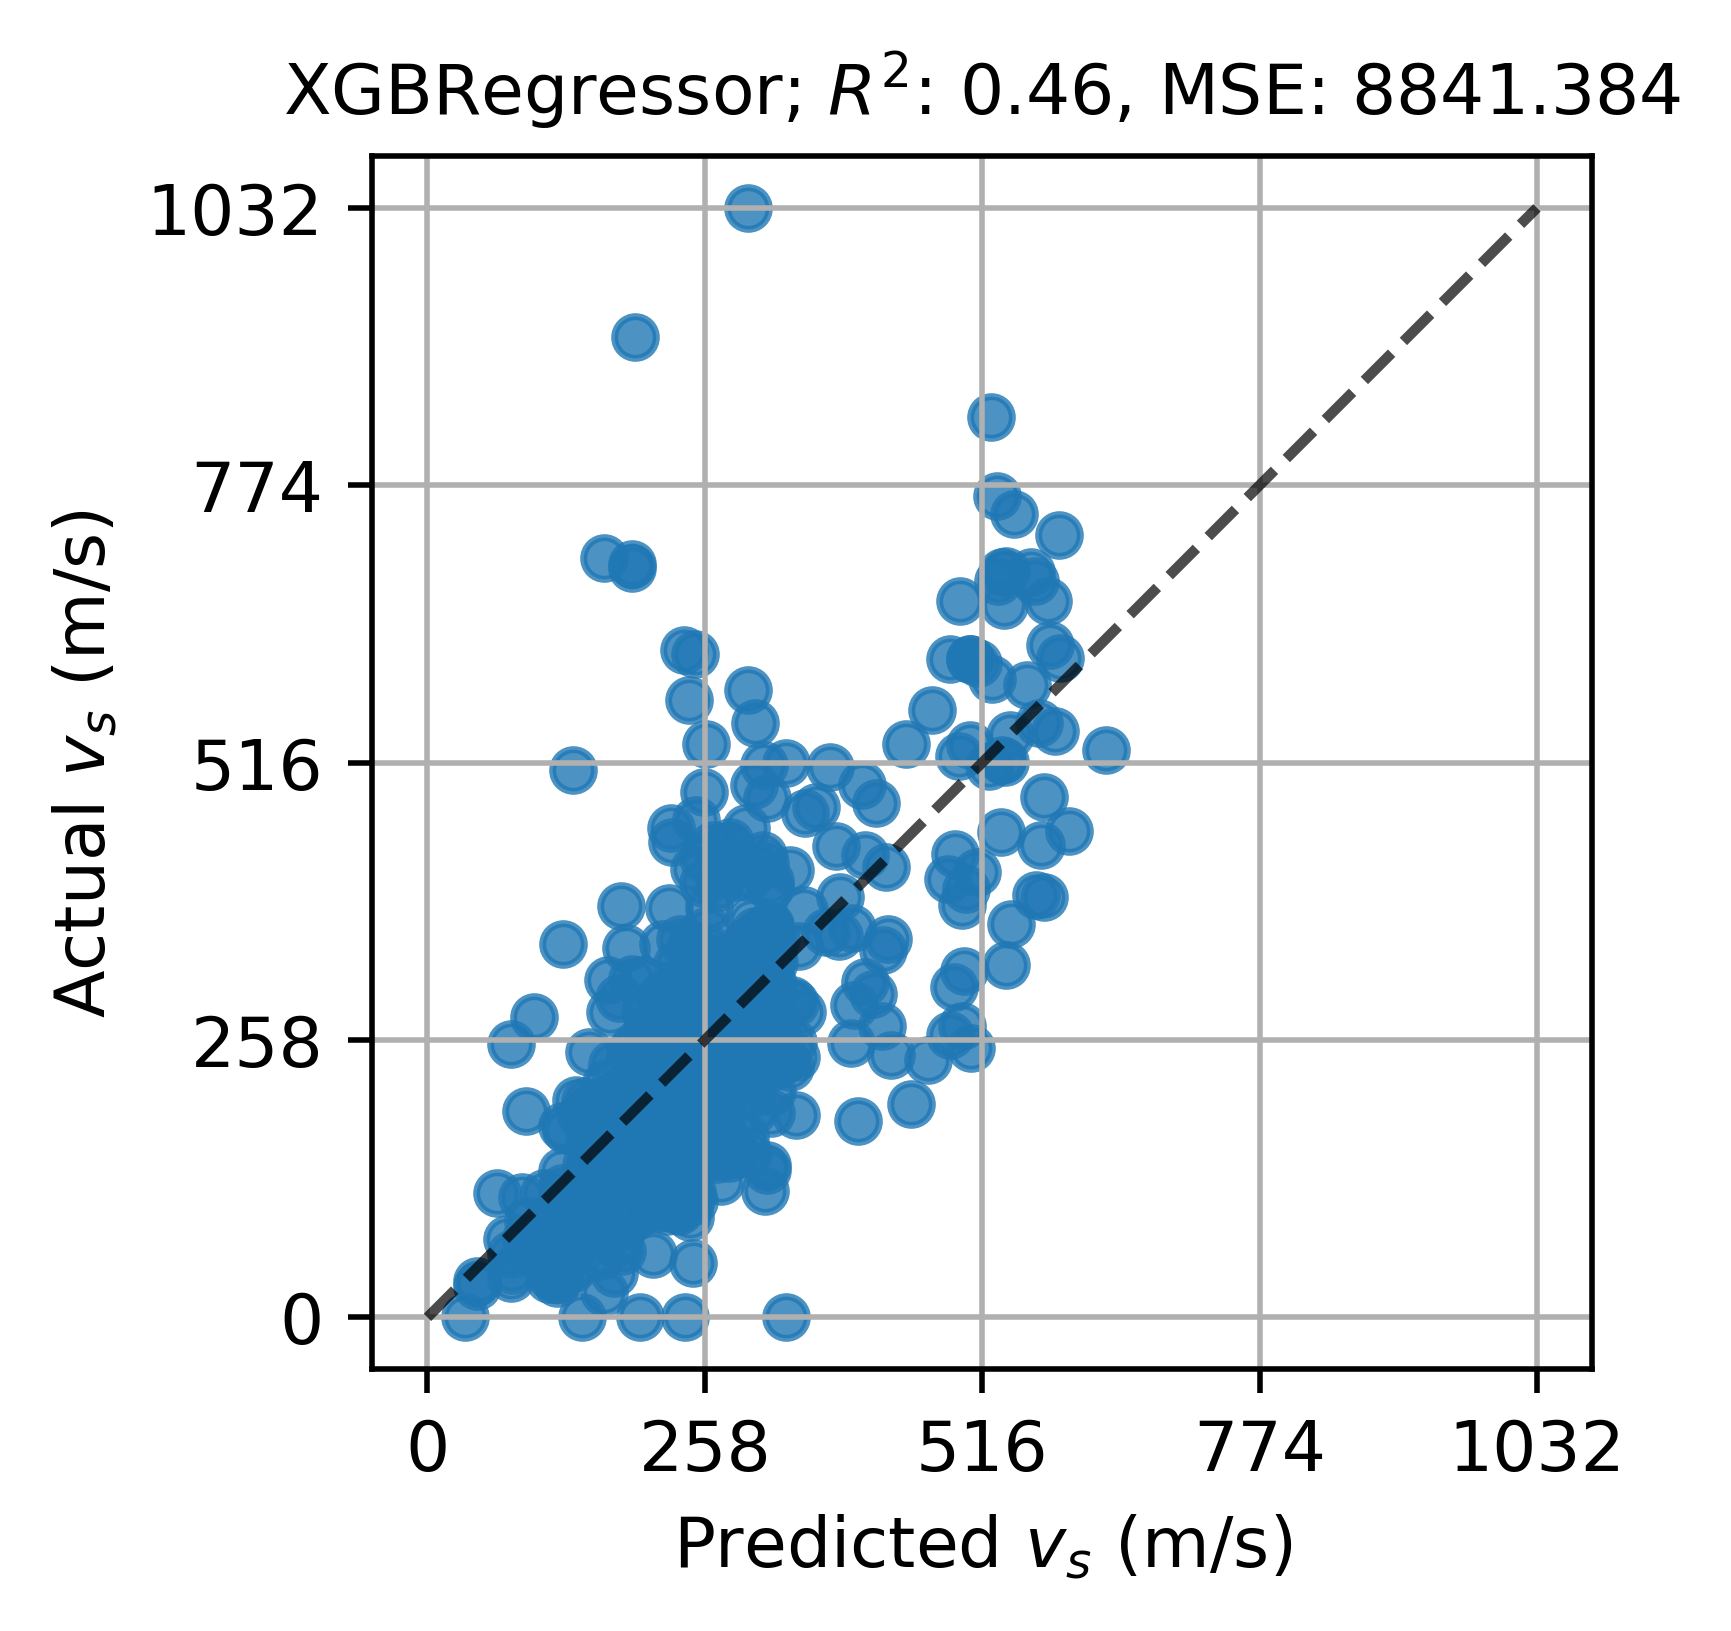

In [49]:
error_plot((8*cm, 8*cm), y_test, y_pred, f'XGBRegressor; $R^2$: {round(score, 3)}, MSE: {round(mse, 3)}')

In [50]:
print('Performance of XGB ML model on train data:\n')
# Check performance on train data
y_pred = final_model.predict(X_train)
# Calculate the R-squared score, Mean squared error
score = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
print(f'Training Data - R2: {round(score, 3)}, MSE: {round(mse, 3)}.')

Performance of XGB ML model on train data:

Training Data - R2: 0.54, MSE: 9680.648.


In [51]:
# =============================================================================
# Training of machine learning model
# =============================================================================
from sklearn.ensemble import HistGradientBoostingRegressor

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 50),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.01, 1),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.5, log=True),
        'loss': "squared_error",
    }

    model = HistGradientBoostingRegressor(**params)
    score = cross_val_score(model, X=X_train, y=y_train, scoring="r2", n_jobs=-1, cv=10, verbose=0)
    
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-02-08 09:23:43,989] A new study created in memory with name: no-name-b7d70b47-36fd-4079-baf4-7bc0c63f6a49
[I 2024-02-08 09:23:45,142] Trial 0 finished with value: 0.4021662658756736 and parameters: {'max_depth': 78, 'max_leaf_nodes': 33, 'l2_regularization': 0.6717278745422748, 'min_samples_leaf': 42, 'learning_rate': 0.01871665095523418}. Best is trial 0 with value: 0.4021662658756736.
[I 2024-02-08 09:23:45,943] Trial 1 finished with value: 0.27107219453889164 and parameters: {'max_depth': 43, 'max_leaf_nodes': 26, 'l2_regularization': 0.08472065222212245, 'min_samples_leaf': 9, 'learning_rate': 0.005750996509298698}. Best is trial 0 with value: 0.4021662658756736.
[I 2024-02-08 09:23:46,172] Trial 2 finished with value: 0.28384993373276324 and parameters: {'max_depth': 98, 'max_leaf_nodes': 5, 'l2_regularization': 0.26465117112759623, 'min_samples_leaf': 31, 'learning_rate': 0.009482966123155547}. Best is trial 0 with value: 0.4021662658756736.
[I 2024-02-08 09:23:46,565] Tr

In [52]:
# Plot optimization history
plot_optimization_history(study)

In [53]:
# Plot parameter importances
plot_param_importances(study)

In [54]:
#Print best hyperparameters of the optimization
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'max_depth': 77, 'max_leaf_nodes': 25, 'l2_regularization': 0.4409836103893504, 'min_samples_leaf': 42, 'learning_rate': 0.03121046940447945}
Best RMSE: 0.4138384591235301


In [55]:
best_params = {
    'max_depth': 1,
    'max_leaf_nodes': 2,
    'l2_regularization': 1,
    'min_samples_leaf': 1,
    'learning_rate': 1,
    'loss': "squared_error",
}

# Update with the best hyperparameters
best_params.update(study.best_params)

# Create the final XGBRegressor with the best hyperparameters
final_model = HistGradientBoostingRegressor(**best_params)

# Train the final model on the entire training set
final_model.fit(X_train, y_train)

HistGradientBoostingRegressor(l2_regularization=0.4409836103893504,
                              learning_rate=0.03121046940447945, max_depth=77,
                              max_leaf_nodes=25, min_samples_leaf=42)

In [56]:
print('Performance of HistGradientBoostingRegressor ML model:\n')
# Check performance on test data
y_pred = final_model.predict(X_test)
# Calculate the R-squared score, Mean squared error
score = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Test Data - R2: {round(score, 3)}, MSE: {round(mse, 3)}.')

Performance of HistGradientBoostingRegressor ML model:

Test Data - R2: 0.458, MSE: 8886.586.


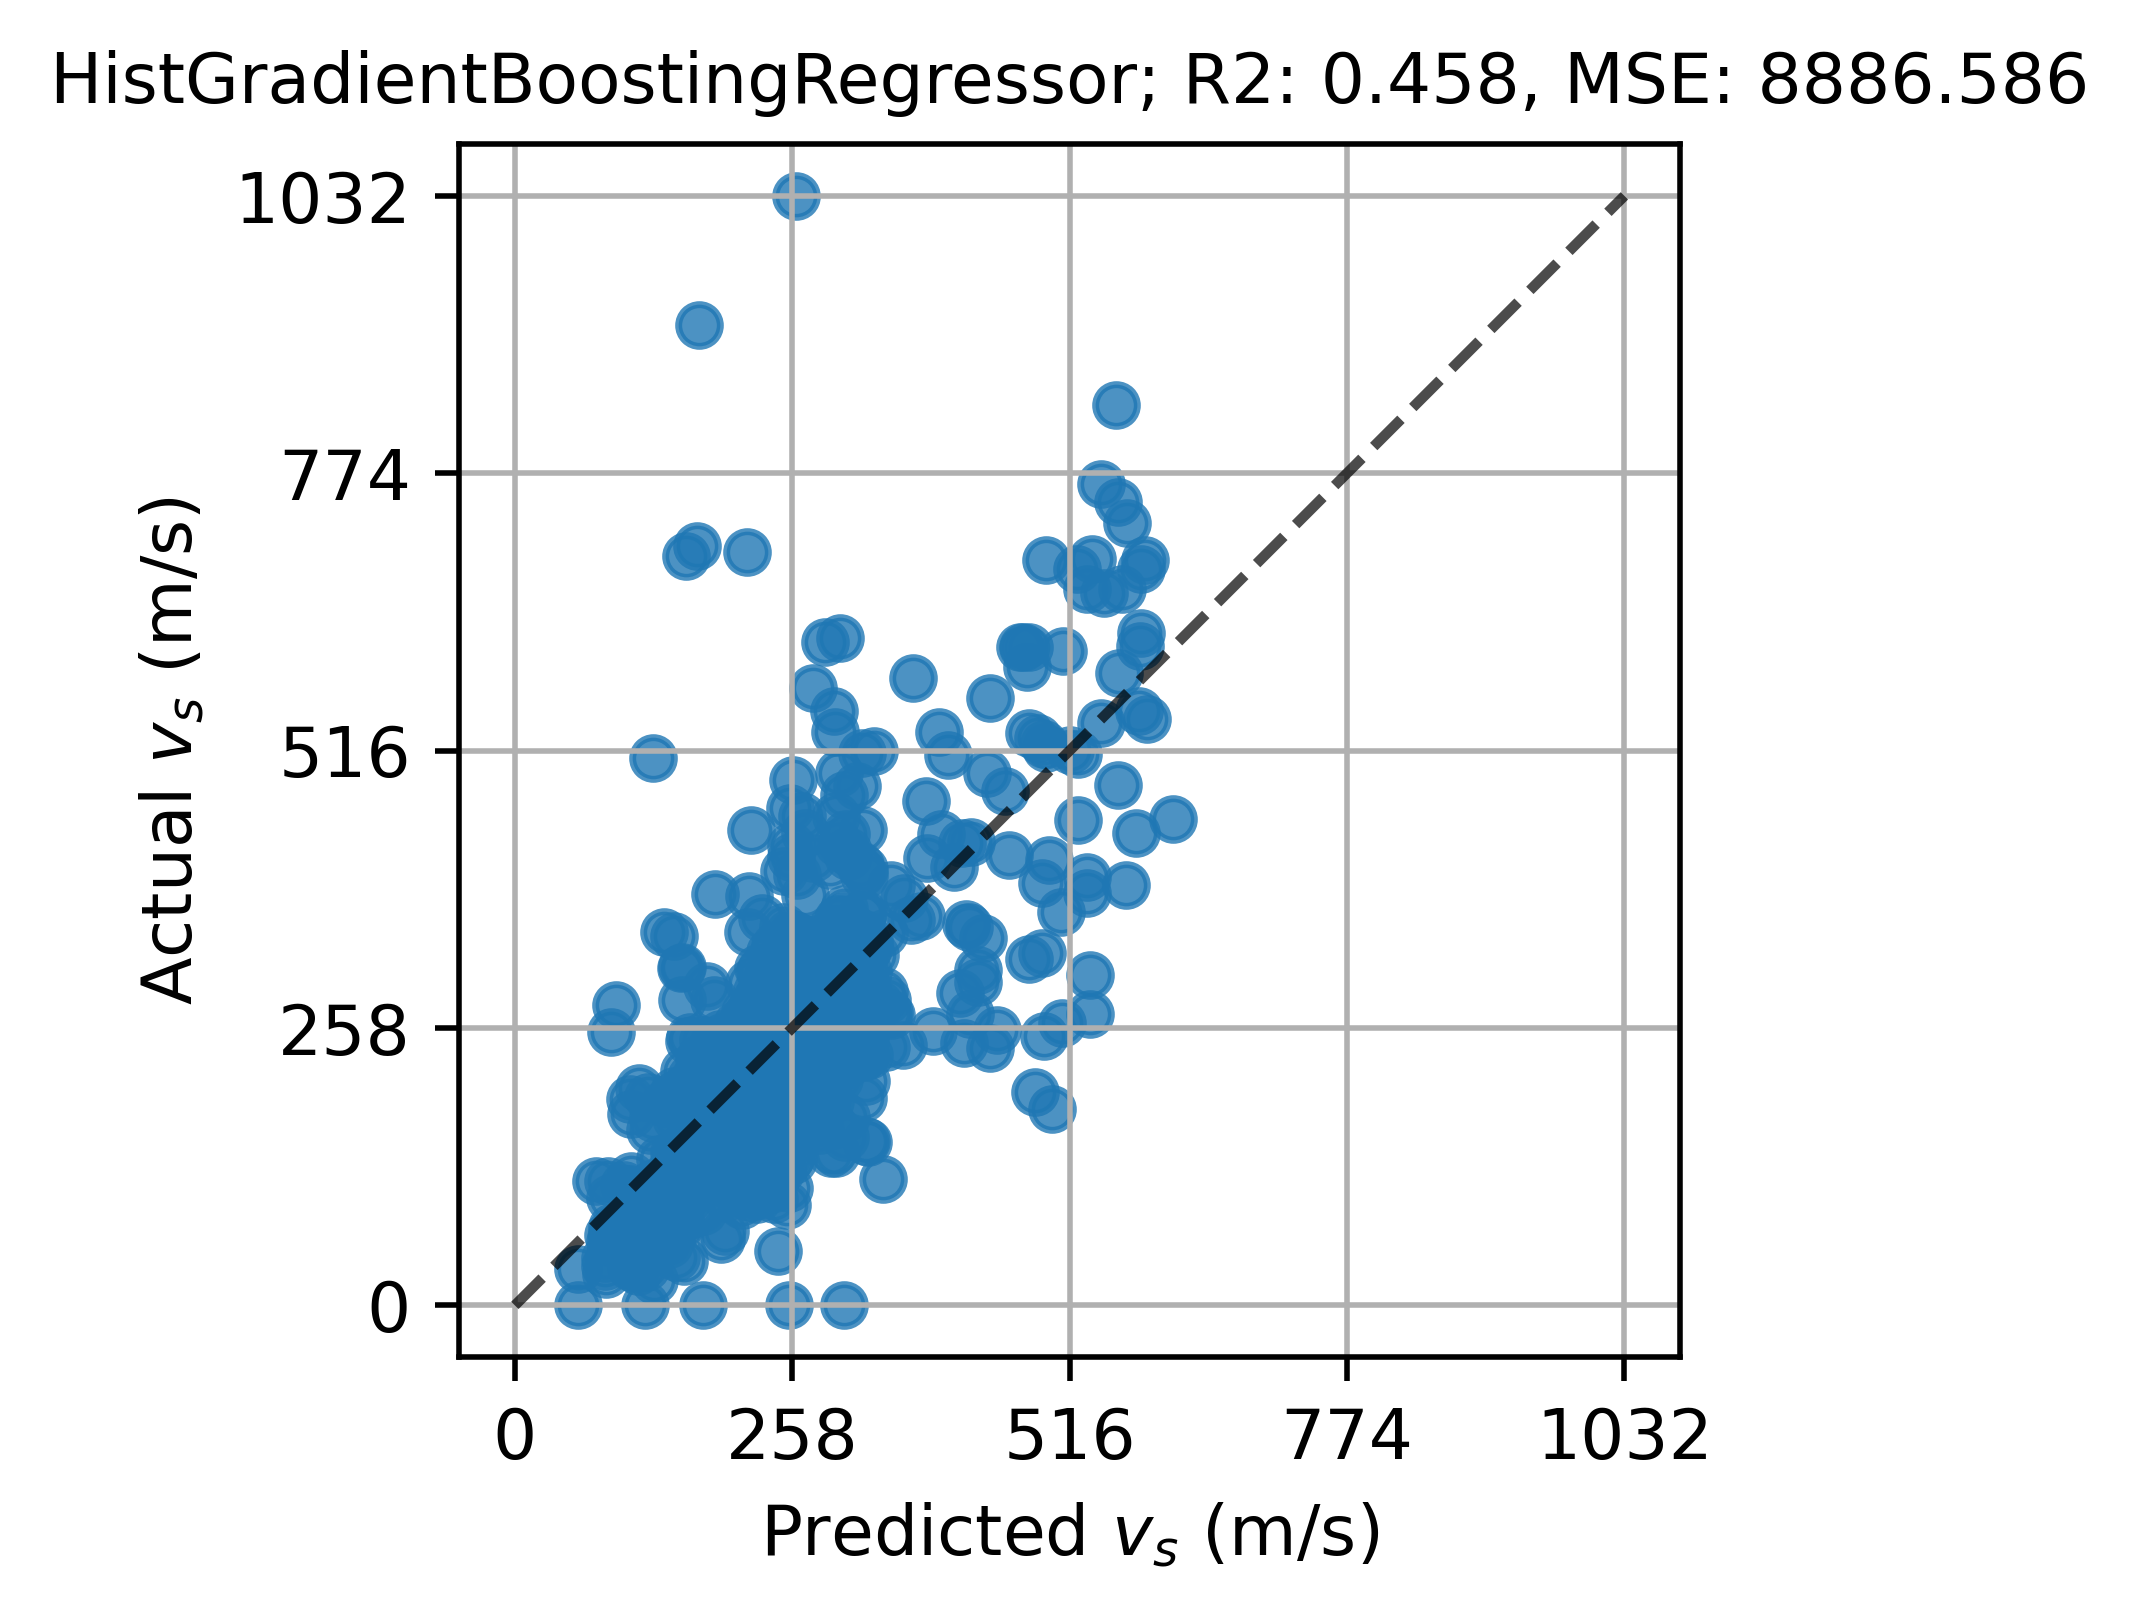

In [57]:
error_plot((8*cm, 8*cm), y_test, y_pred, f'HistGradientBoostingRegressor; R2: {round(score, 3)}, MSE: {round(mse, 3)}')

In [58]:
# Check performance on train data
y_pred = final_model.predict(X_train)
# Calculate the R-squared score, Mean squared error
score = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
print(f'Training Data - R2: {round(score, 3)}, MSE: {round(mse, 3)}.')

Training Data - R2: 0.512, MSE: 10269.467.


In [59]:
from sklearn.ensemble import RandomForestRegressor

check_column = []
check = 0

for column in selected_columns_x[:-1]:
    if df_SCPTu_SCPT[column].isnull().any():
        check_column.append('nan')
        check = 0
    else:
        check_column.append('non_nan')
        check = 1

    if check == 0:
        # Handle the case when at least one column contains NaN values
        pass
    elif check == 1:
        # Drop rows with NaN values in the selected columns
        df_SCPTu_SCPT.dropna(subset=selected_columns_x[:-1], inplace=True)

X = df_SCPTu_SCPT[selected_columns_x[:-1]]
y = df_SCPTu_SCPT['Vs (m/s)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [60]:
def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 50),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 50),
        'max_samples': trial.suggest_int('max_samples', 1, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 1, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'n_jobs': None,
        'criterion': "squared_error",
    }
    model = RandomForestRegressor(**params)
    score = cross_val_score(model, X=X_train, y=y_train, scoring="r2", n_jobs=-1, cv=10, verbose=0)
    
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-02-08 09:25:13,460] A new study created in memory with name: no-name-dfabef29-62ab-48d4-a488-3e5154d7da5d
[I 2024-02-08 09:25:16,065] Trial 0 finished with value: -0.008829524213536933 and parameters: {'n_estimators': 711, 'max_depth': 3, 'max_leaf_nodes': 5, 'max_samples': 28, 'min_samples_split': 22, 'min_samples_leaf': 39}. Best is trial 0 with value: -0.008829524213536933.
[I 2024-02-08 09:25:18,507] Trial 1 finished with value: -0.009514585987807567 and parameters: {'n_estimators': 567, 'max_depth': 44, 'max_leaf_nodes': 39, 'max_samples': 8, 'min_samples_split': 19, 'min_samples_leaf': 17}. Best is trial 0 with value: -0.008829524213536933.
[I 2024-02-08 09:25:20,672] Trial 2 finished with value: -0.009165633278214824 and parameters: {'n_estimators': 346, 'max_depth': 3, 'max_leaf_nodes': 11, 'max_samples': 36, 'min_samples_split': 32, 'min_samples_leaf': 47}. Best is trial 0 with value: -0.008829524213536933.
[I 2024-02-08 09:25:22,408] Trial 3 finished with value: -0.00

In [61]:
# Plot optimization history
plot_optimization_history(study)

In [62]:
# Plot parameter importances
plot_param_importances(study)

In [63]:
#Print best hyperparameters of the optimization
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 259, 'max_depth': 39, 'max_leaf_nodes': 18, 'max_samples': 49, 'min_samples_split': 1, 'min_samples_leaf': 1}
Best RMSE: 0.34718828345593755


In [64]:
best_params = {
    'n_estimators': 1,
    'max_depth': 1,
    'max_leaf_nodes': 2,
    'max_samples': 1,
    'min_samples_split': 1,
    'min_samples_leaf': 1,
    'n_jobs': None,
    'criterion': "squared_error",
}

# Update with the best hyperparameters
best_params.update(study.best_params)

# Create the final XGBRegressor with the best hyperparameters
final_model = RandomForestRegressor(**best_params)

# Train the final model on the entire training set
final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=39, max_leaf_nodes=18, max_samples=49,
                      min_samples_split=1, n_estimators=259)

In [65]:
print('Performance of RandomForestRegressor ML model:\n')
# Check performance on test data
y_pred = final_model.predict(X_test)
# Calculate the R-squared score, Mean squared error
score = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Test Data - R2: {round(score, 3)}, MSE: {round(mse, 3)}.')

Performance of RandomForestRegressor ML model:

Test Data - R2: 0.405, MSE: 11855.787.


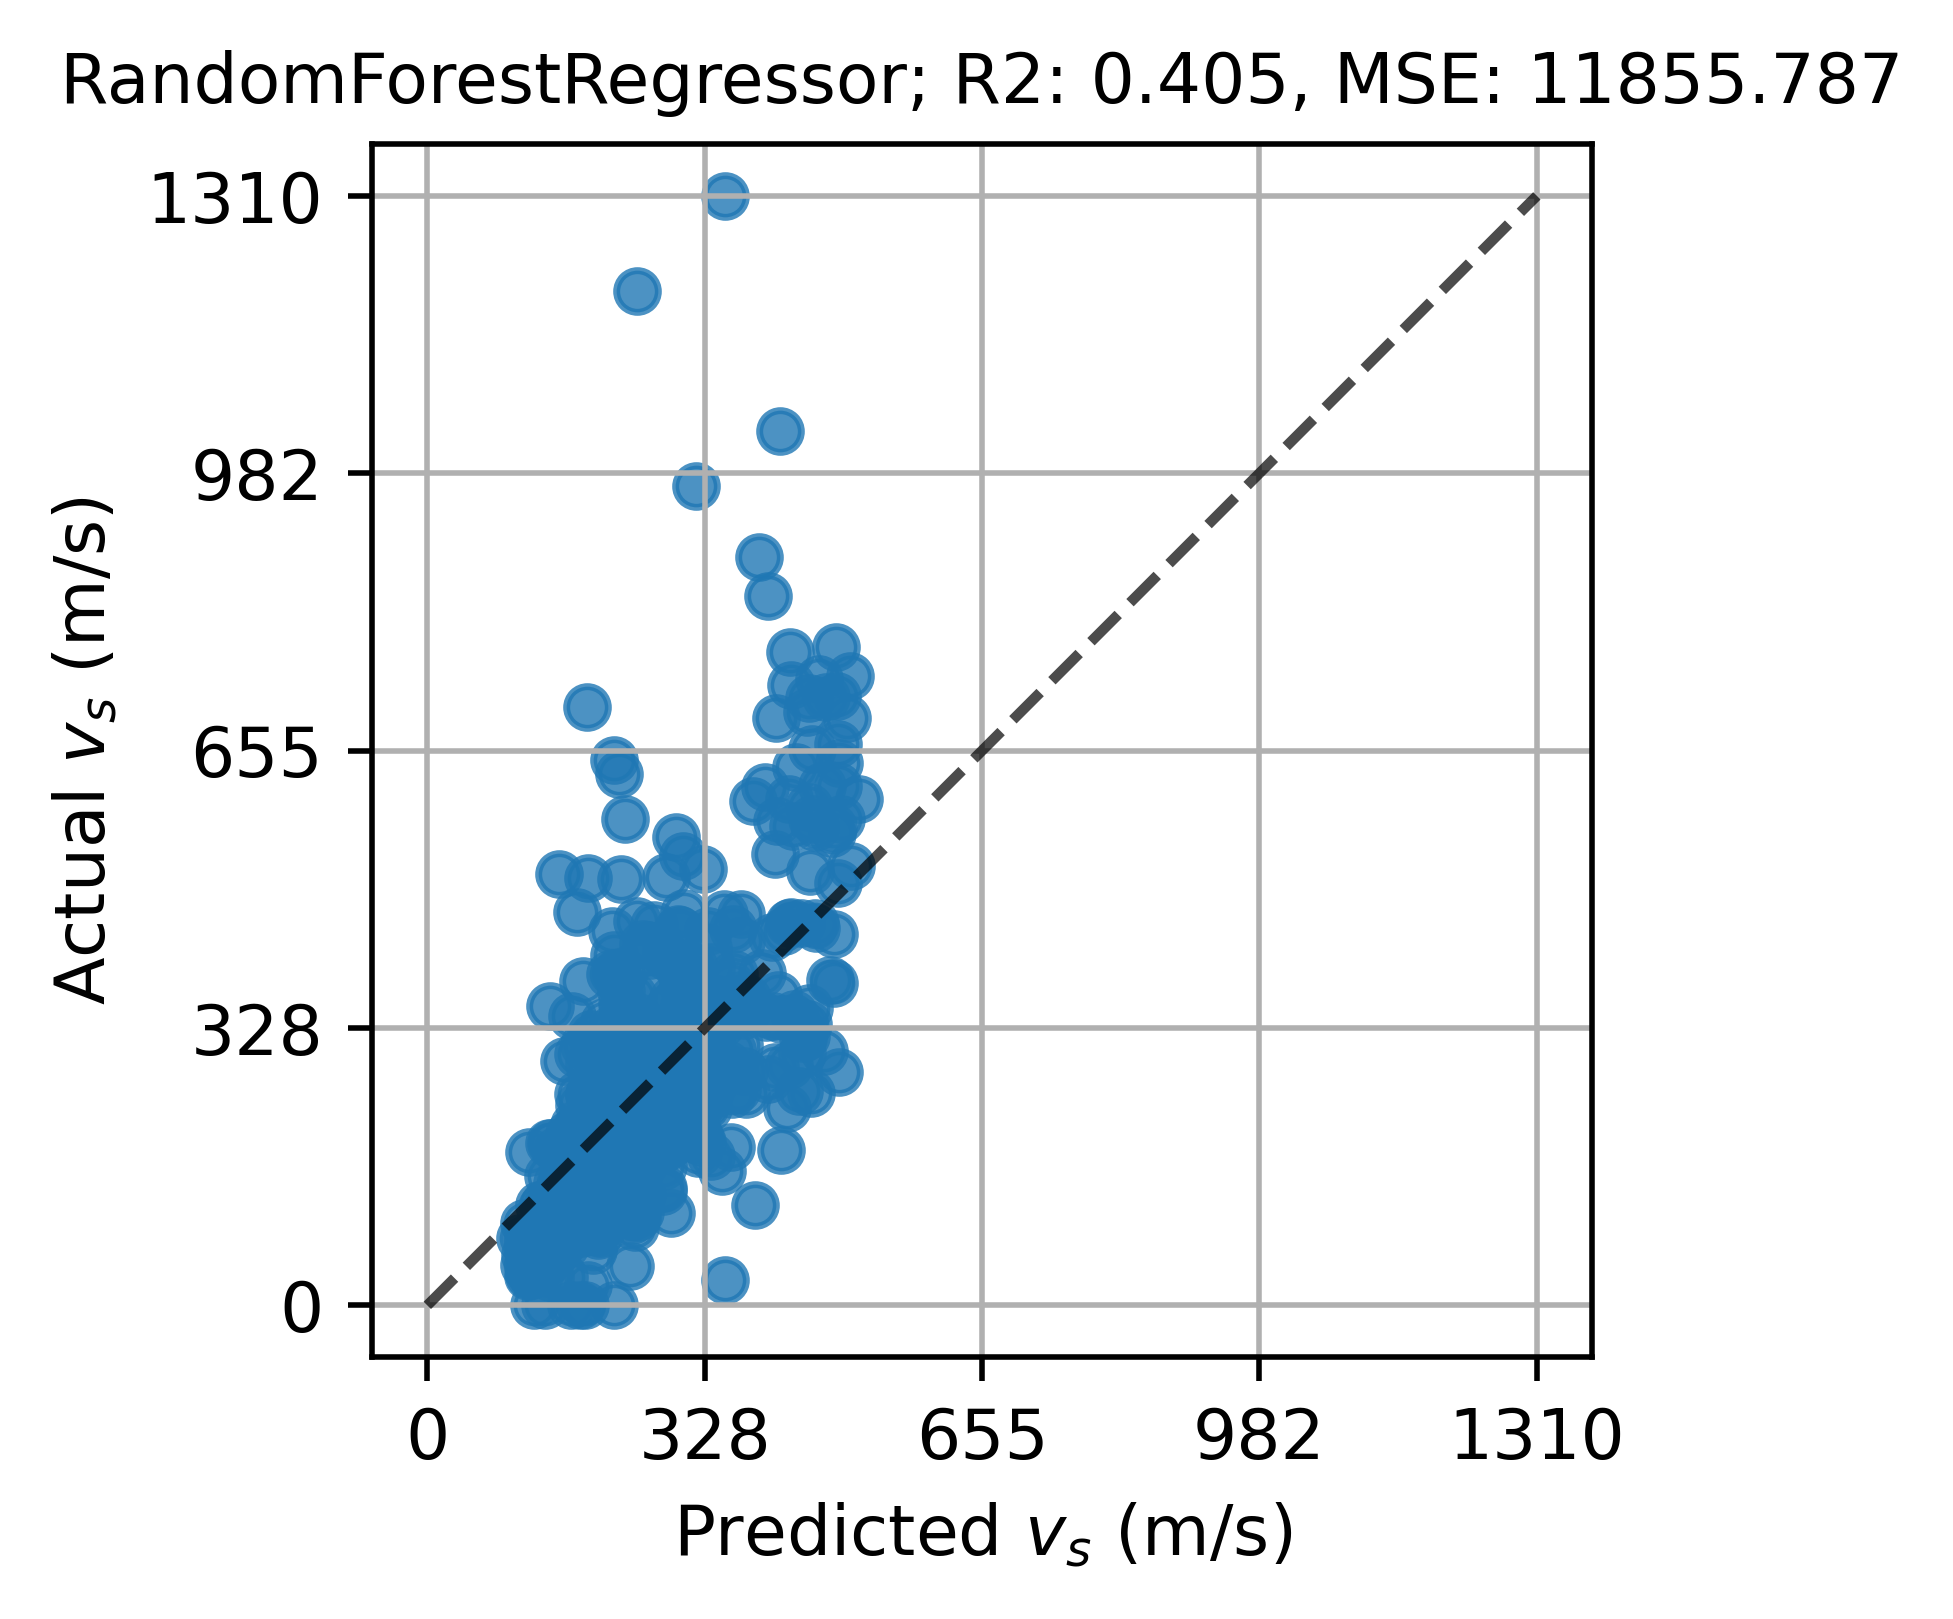

In [66]:
error_plot((8*cm, 8*cm), y_test, y_pred, f'RandomForestRegressor; R2: {round(score, 3)}, MSE: {round(mse, 3)}')

In [67]:
# Check performance on train data
y_pred = final_model.predict(X_train)
# Calculate the R-squared score, Mean squared error
score = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
print(f'Training Data - R2: {round(score, 3)}, MSE: {round(mse, 3)}.')

Training Data - R2: 0.369, MSE: 12697.844.
